# Adult Census Income 

## Table of content :
1. <a href='#DP'>Data Processing</a>
1. <a href='#M'>Modeling</a>
1. <a href='#MT'>Models Tuning (By Grid Search)</a>

<a id="DP"></a>
## Reading & preprocessing 

In [2]:
#importing the necessary libraries
%matplotlib inline  
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns #used to plot categorical data
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings('ignore')

In [3]:
#downloading the data, setting the headers, removing spaces
train_data_link = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_data_link = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
train_data_original = pd.read_csv(train_data_link,names=["age","workclass","fnlwgt","education","education_num","martial_status","occupation","relationship","race","sex","capital_gain","capital_loss","hours_per_week","native_country","income"],skipinitialspace=True,na_values='?')
test_data_original  = pd.read_csv(test_data_link,names=["age","workclass","fnlwgt","education","education_num","martial_status","occupation","relationship","race","sex","capital_gain","capital_loss","hours_per_week","native_country","income"],skipinitialspace=True,skiprows=1,na_values='?')

In [5]:
train_data = train_data_original.copy()
test_data = test_data_original.copy()


To better understand the data, I'll use the built-in Pandas functions
```python
    pandas.DataFrame.info
    pandas.DataFrame.describe
```

In [6]:
print(train_data.info())
print(train_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
martial_status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    31978 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None
                age        fnlwgt  education_num  capital_gain  capital_loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
st

**Conclusions :**<br>
1. The data has both categorical and numerical columns
2. Some columns has missing values (workclass, occupation, native country).
   I'm planning to replace those values with the most frequent value
3. The numirical data needs to be scaled
4. The numirical data is complete (there are no mising values)

*Using the same commands for the test set results in the same conclusions*

<div class="alert alert-block alert-info">
Using the same commands for the test set results in the same conclusions

To better understand the data, I'll try to visualize both numerical and categorical data.

**Numerical Data Visualization :**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6a77d275f8>,
      dtype=object)

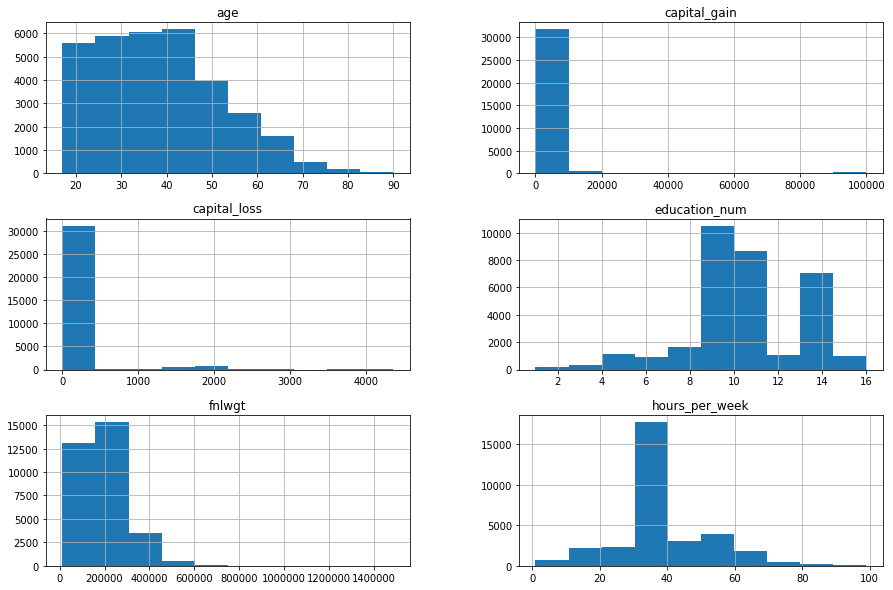

In [7]:
num_features = train_data.select_dtypes(include=['int64'])
num_features.hist(figsize=(15,10))

I'll use __countplot__ function from __seaborn__ library to visualize the frequancy between the different classifications of the catergorigcal data verses the income

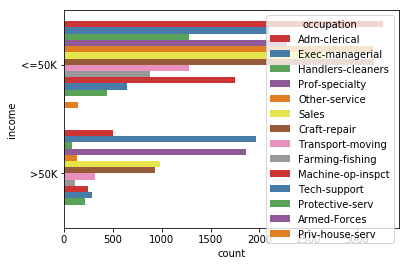

In [8]:
cat_features = train_data.select_dtypes(include=['object'])
# sns.countplot(y='martial_status', hue='income', data = cat_features)
sns.countplot(y='income', hue='occupation', data = cat_features,palette="Set1")

#### We need to check the missing values in our data.

To check how many missing values in each column, I used the following code:
```python
train_data.isna().sum()
```
The results are : 

In [9]:
train_data.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
martial_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64

<div class="alert alert-block alert-info">
The Test data has missing values in the same columns, too. 

In [10]:
#preparing the last column for binary classification.
train_data.replace('<=50K',0,inplace=True)
train_data.replace('>50K',1,inplace=True)

test_data.replace('<=50K.',0,inplace=True)
test_data.replace('>50K.',1,inplace=True)


<div class="alert alert-block alert-warning">
    Rows with some missing data can't be eliminated, since they make up a considerable proportion of the data. Namely, 7% of the rows of the train/test data include missing values.<br>

\[ The percentage is found using the following line\]
```python
100*(train_data.shape[0] - train_data.dropna(how="any").shape[0])/train_data.shape[0]
```

One way of dealing with missing data is to replace it with the most frequent value.<br>
__Replacing NA values with the most frequent value in each column (the mode) :__

In [11]:
test_data.fillna(test_data.mode().iloc[0],inplace=True)
train_data.fillna(train_data.mode().iloc[0],inplace=True)

In the next input, I'm gonna drop 2 columns. `fnlwgt` and `education`<br>
The first column is contextually irrelevant, and dropping it has contributed much to the accuracy of the prediction.<br>
The information held by the `education` column is already provided in the `education_num` column. so it's redundant.

In [12]:
train_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)
test_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)

train_data=train_data[train_data.native_country!='Holand-Netherlands'] # Prevents an error from occuring [I know the reason, and I'll ask about a more professional workaround in the lecture]

<a id='id'></a>

In [13]:
test_data.isna().sum() # Double check

age               0
workclass         0
education_num     0
martial_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

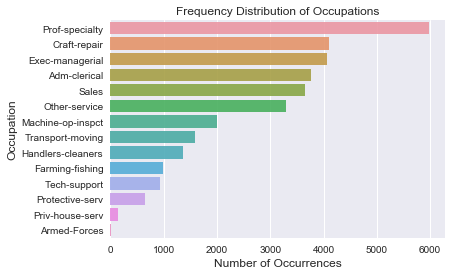

In [14]:
occ_count = train_data['occupation'].value_counts()
sns.set(style="darkgrid")
sns.barplot(occ_count.values,occ_count.index, alpha=0.9)
plt.title('Frequency Distribution of Occupations')
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.show()

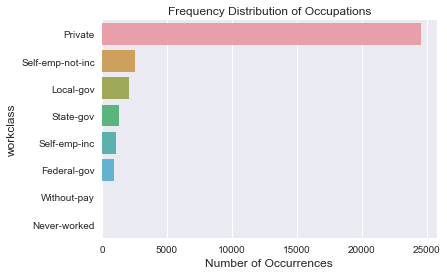

In [15]:
workclass_count = train_data['workclass'].value_counts()
sns.set(style="darkgrid")
sns.barplot(workclass_count.values,workclass_count.index, alpha=0.9)
plt.title('Frequency Distribution of Occupations')
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('workclass', fontsize=12)
plt.show()

In [16]:
train_data_oneHot=pd.get_dummies(train_data)
test_data_oneHot=pd.get_dummies(test_data)

In [17]:
x_train = train_data_oneHot.drop('income', axis=1)
x_test  = test_data_oneHot.drop('income', axis=1)
y_train = train_data_oneHot['income']
y_test  = test_data_oneHot['income']

#### Normalization

In [20]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_train_normalized=  pd.DataFrame(min_max_scaler.fit_transform(x_train))
x_test_normalized=  pd.DataFrame(min_max_scaler.fit_transform(x_test))

<a id="M"></a>
# Modeling

LR: 0.841093 (0.006172) [CV]
LR: 0.846692  [TEST]
DT: 0.820700 (0.008117) [CV]
DT: 0.823045  [TEST]
KNN: 0.849509 (0.005728) [CV]
KNN: 0.850746  [TEST]


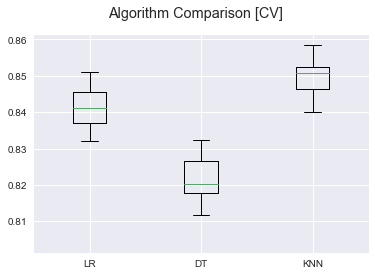

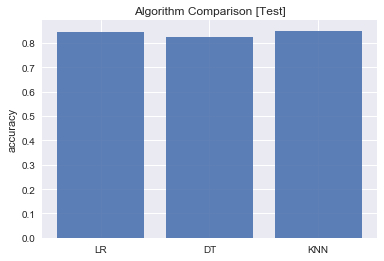

In [23]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
models=[]
models.append(('LR', LogisticRegression(solver = 'lbfgs', max_iter=200)))
models.append(('DT', tree.DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))

results = []
test_results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=17)
    cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg1 = "%s: %f (%f) [CV]" % (name, cv_results.mean(), cv_results.std())
    model.fit(x_train, y_train)
    test_score=model.score(x_test,y_test)
    test_results.append(test_score)
    msg2 = "%s: %f  [TEST]" % (name, test_score)
    print(msg1)
    print(msg2)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison [CV]')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

objects = names
y_pos = np.arange(len(objects))
performance = test_results
 
plt.bar(y_pos, performance, align='center', alpha=0.9)
plt.xticks(y_pos, objects)
plt.ylabel('accuracy')
plt.title('Algorithm Comparison [Test]')
 
plt.show()

I didn't use the Normalized version of the dataframe because when I tried it, it's showed results with less accuracy as follows : <br>
LR: 0.796714 (0.006568) [CV] <br>
LR: 0.798661  [TEST]<br>
DT: 0.820424 (0.007053) [CV]<br>
DT: 0.822001  [TEST]<br>
KNN: 0.849509 (0.005728) [CV]<br>
KNN: 0.850746  [TEST]<br>

In [19]:
from sklearn.svm import SVC
rfe = RFE(model, 50)
fit = rfe.fit(x_train.values, y_train.values)
x_train=rfe.transform(x_train)
x_test=rfe.transform(x_test)

In [20]:
model.fit(x_train,y_train) #Takes a LONG time

SVC(C=1.0, cache_size=10000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [35]:
model.score(x_test,y_test)

0.8658076285240464

<a id="MT"></a>
# Grid Search 

## SVM

In [27]:
#Grid Search
C_values = [1, 3, 10, 30, 100]  
gamma_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]

best_score = 0  
best_params = {'C': None, 'gamma': None}

for C in C_values:  
    for gamma in gamma_values:
        print("Checking C:",C,  'gamma: ', gamma)
        svc = svm.SVC(C=C, gamma=gamma)
        svc.fit(x_train, y_train)
        score = svc.score(x_test, y_test)
        print("Result :", score)
        if score > best_score:
            best_score = score
            best_params['C'] = C
            best_params['gamma'] = gamma
            print("*") 

best_score, best_params 
# takes many hours to execute

Checking C: 1 gamma:  0.01
Result : 0.8672071740065107
*
Checking C: 1 gamma:  0.03
Result : 0.8634604754007739
Checking C: 1 gamma:  0.1
Result : 0.8512376389656655
Checking C: 1 gamma:  0.3
Result : 0.817148823782323
Checking C: 1 gamma:  1
Result : 0.7800503654566673
Checking C: 1 gamma:  3
Result : 0.7715742276272957
Checking C: 1 gamma:  10
Result : 0.7715742276272957
Checking C: 1 gamma:  30
Result : 0.7715742276272957
Checking C: 1 gamma:  100
Result : 0.7715742276272957
Checking C: 3 gamma:  0.01
Result : 0.8697254468398747
*
Checking C: 3 gamma:  0.03
Result : 0.8614949941649775
Checking C: 3 gamma:  0.1
Result : 0.8457097229899884
Checking C: 3 gamma:  0.3
Result : 0.814262023217247
Checking C: 3 gamma:  1
Result : 0.782445795712794
Checking C: 3 gamma:  3
Result : 0.7715742276272957
Checking C: 3 gamma:  10
Result : 0.7715742276272957
Checking C: 3 gamma:  30
Result : 0.7715742276272957
Checking C: 3 gamma:  100
Result : 0.7715742276272957
Checking C: 10 gamma:  0.01
Result 

(0.8697254468398747, {'C': 3, 'gamma': 0.01})

Out : (0.8697254468398747, {'C': 3, 'gamma': 0.01})

In [ ]:
SVM_best_score=best_score
SVM_best_model= SVM()
SVM_best_model.set_params(**best_params)

## Decision Tree

In [93]:
from sklearn.model_selection import GridSearchCV
parameters={'min_samples_split' : range(10,500,20),'max_depth': range(1,100,5)}
clf_tree=tree.DecisionTreeClassifier()
clf_dt=GridSearchCV(clf_tree,parameters)
clf_dt.fit(x_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': range(10, 500, 20), 'max_depth': range(1, 100, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [94]:
DT_best_score=clf_dt.best_score_
DT_best_model= DecisionTreeClassifier()
DT_best_model.set_params(**(clf_dt.best_params_))
DT_best_model.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=86,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=190,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## KNN

In [101]:
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier()
parameters = {'n_neighbors':[4,5,6,7],
              'leaf_size':[1,3,5],
              'algorithm':['auto', 'kd_tree'],
              'n_jobs':[-1]}
clf_knn=GridSearchCV(knn,parameters)
clf_knn.fit(x_train,y_train)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [4, 5, 6, 7], 'leaf_size': [1, 3, 5], 'algorithm': ['auto', 'kd_tree'], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [102]:
KNN_best_score=clf_knn.best_score_
KNN_best_model= KNeighborsClassifier()
KNN_best_model.get_params().keys()
KNN_best_model.set_params(**(clf_knn.best_params_))
KNN_best_model.fit(x_train,y_train)
#{'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 6}


KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=6, p=2,
           weights='uniform')

## Logistic Regrission

In [97]:
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)
logistic = LogisticRegression()
clf_lr = GridSearchCV(logistic, hyperparameters, cv=5, verbose=2)
clf_lr.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=1.0, penalty=l1 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ C=1.0, penalty=l1, total=   0.5s
[CV] C=1.0, penalty=l1 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ................................ C=1.0, penalty=l1, total=   0.6s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.2s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.6s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.4s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.1s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.1s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.1s
[CV] C=1.0, penalty=l2 ...............................................
[CV] .

[CV] C=464.15888336127773, penalty=l1 ................................
[CV] ................. C=464.15888336127773, penalty=l1, total=   0.1s
[CV] C=464.15888336127773, penalty=l1 ................................
[CV] ................. C=464.15888336127773, penalty=l1, total=   0.1s
[CV] C=464.15888336127773, penalty=l1 ................................
[CV] ................. C=464.15888336127773, penalty=l1, total=   0.1s
[CV] C=464.15888336127773, penalty=l1 ................................
[CV] ................. C=464.15888336127773, penalty=l1, total=   0.1s
[CV] C=464.15888336127773, penalty=l1 ................................
[CV] ................. C=464.15888336127773, penalty=l1, total=   0.1s
[CV] C=464.15888336127773, penalty=l2 ................................
[CV] ................. C=464.15888336127773, penalty=l2, total=   0.1s
[CV] C=464.15888336127773, penalty=l2 ................................
[CV] ................. C=464.15888336127773, penalty=l2, total=   0.1s
[CV] C

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   23.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e+00, 2.78256e+00, 7.74264e+00, 2.15443e+01, 5.99484e+01,
       1.66810e+02, 4.64159e+02, 1.29155e+03, 3.59381e+03, 1.00000e+04]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [98]:
LR_best_score=clf_lr.best_score_
LR_best_model= LogisticRegression()
LR_best_model.set_params(**(clf_lr.best_params_))
LR_best_model.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

# Summary

[Logistic Regresstion] : 0.8513
[KNearest Neighbor] : 0.8518
[SVM] : 0.8697
[Decision Trees] : 0.8570


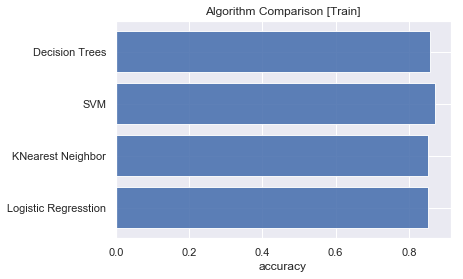

In [108]:
objects = ['Logistic Regresstion','KNearest Neighbor','SVM','Decision Trees']
x_pos = np.arange(len(objects))
performance = [LR_best_score,KNN_best_score,SVM_best_score,DT_best_score]
 
for (i,j) in zip(objects,performance):
    print("[%s] : %.4f" % (i,j))
    
plt.barh(x_pos, performance, align='center', alpha=0.9)
plt.yticks(x_pos, objects)
plt.xlabel('accuracy')
plt.title('Algorithm Comparison [Train]')
 
plt.show()

[Logistic Regresstion] : 0.8517
[KNearest Neighbor] : 0.8556
[SVM] : 0.8625
[Decision Trees] : 0.8569


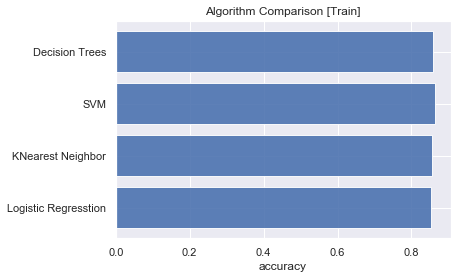

In [107]:
objects = ['Logistic Regresstion','KNearest Neighbor','SVM','Decision Trees']
x_pos = np.arange(len(objects))
performance =[]
performance.append(LR_best_model.score(x_test,y_test))
performance.append(KNN_best_model.score(x_test,y_test))
performance.append(SVM_best_model.score(x_test,y_test))
performance.append(DT_best_model.score(x_test,y_test))

for (i,j) in zip(objects,performance):
    print("[%s] : %.4f" % (i,j))

plt.barh(x_pos, performance, align='center', alpha=0.9)
plt.yticks(x_pos, objects)
plt.xlabel('accuracy')
plt.title('Algorithm Comparison [Train]')
plt.show()

SVM Performs slightly better